## Predicting Student Success Rate
Used Tutorial for PCA guidance from https://www.jcchouinard.com/pca-with-python/

Steps:
- Visualize and understand data

In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import missingno as msno
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score

In [3]:
# Read in data and see features
df = pd.read_csv('data.csv', sep=';')
df.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


<AxesSubplot:>

c:\Users\arjun\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


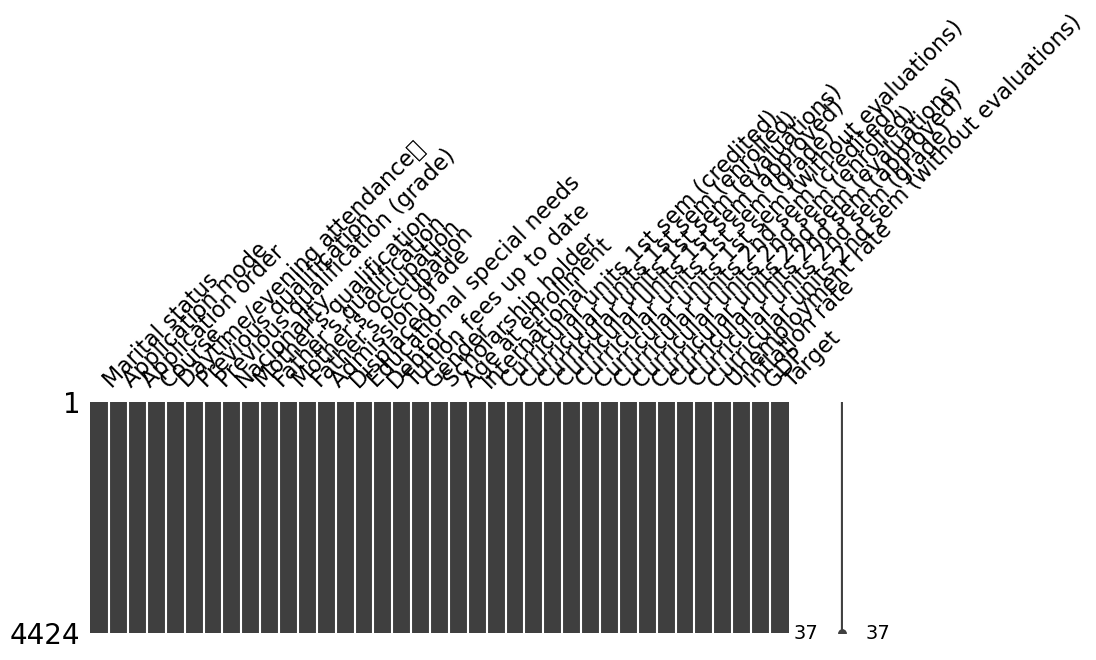

In [4]:
# Missing data detection
msno.matrix(df, figsize = (10,3))

We can see that there are no null entries as all the columns are equally popualted.

- Separate data 80/20 for training/testing

In [5]:
n_train = np.floor(0.8*4224).astype(int)
df_arr = df.to_numpy()
train_data = df_arr[0:n_train, :]
test_data = df_arr[n_train:, :]
print('Training Data Points: ', train_data.shape[0])
print('Testing Data Points: ', test_data.shape[0])

Training Data Points:  3379
Testing Data Points:  1045


In [6]:
# Create X matrix and y vector
X = train_data[:, :-1]
X = StandardScaler().fit_transform(X) # Standardizes features with 0 mean and unit variance
y = train_data[:, -1]
display(y)

# Reformat label with dropout as 0 and graduate as 1
target_names = {0:'Dropout', 1:'Graduate'}
y = y == "Graduate"
y = y.astype(int)
y

array(['Dropout', 'Graduate', 'Dropout', ..., 'Graduate', 'Graduate',
       'Enrolled'], dtype=object)

array([0, 1, 0, ..., 1, 1, 0])


- Next, use Principal Component Analysis (PCA) for dimensionality reduction

    We'll try reducing the 36 original features down to 10

Shape before PCA:  (3379, 36)
Shape after PCA:  (3379, 10)


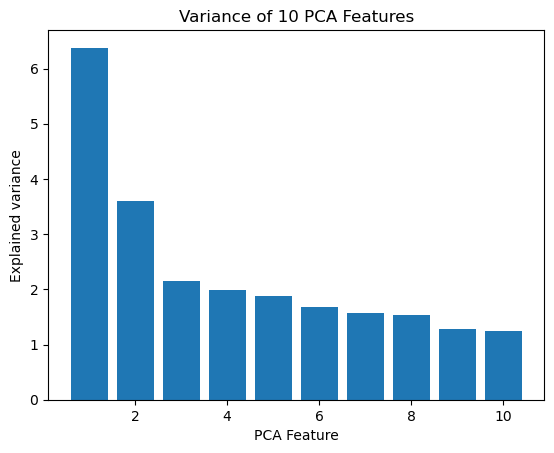

In [7]:
# PCA With 10 Features
pca_10 = decomposition.PCA(n_components=10)
pca_10.fit(X)
X_10 = pca_10.transform(X)
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', X_10.shape)

# Determine variance of the 10 Principal Components (PCs) created by PCA
pca_10.explained_variance_
plt.bar(range(1, len(pca_10.explained_variance_) + 1), pca_10.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Variance of 10 PCA Features')
plt.show()

From this, we can see that the first 2 features seem to be the most informative, so let's perform PCA with 2 features

In [8]:
# PCA With 2 Features
pca_2 = decomposition.PCA(n_components=2)
pca_2.fit(X)
X_2 = pca_2.transform(X)
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', X_2.shape)

Shape before PCA:  (3379, 36)
Shape after PCA:  (3379, 2)


Now lets plot the data after PCA

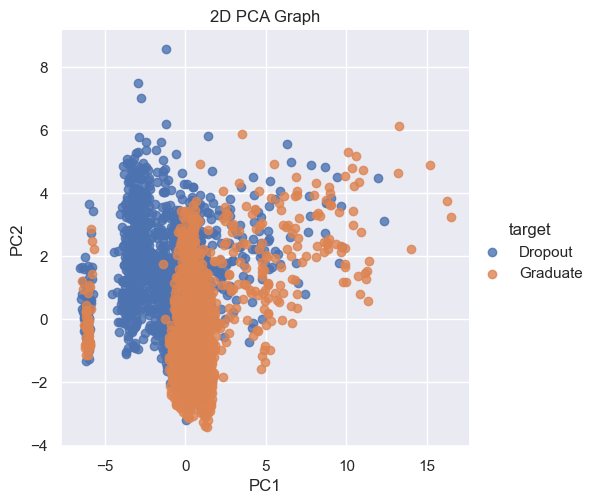

In [9]:
sns.set()
pca_df = pd.DataFrame(data=X_2, columns=['PC1', 'PC2'])
pca_df['target'] = y
pca_df['target'] = pca_df['target'].map(target_names)
sns.lmplot(x='PC1', y='PC2', data=pca_df, hue='target', fit_reg=False, legend=True)
 
plt.title('2D PCA Graph')
plt.show()

Let's see how different features are being taken into account with each principal component

In [10]:
# Principal components correlation coefficients
comps = pca_2.components_
 
# Number of features before PCA
n_features = pca_2.n_features_
 
# Feature names before PCA
feature_names = df.columns[:-1]
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, comps))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2
feature_names,,
Marital status,0.017437,0.251312
Application mode,0.062687,0.358239
Application order,-0.015585,-0.224461
Course,0.136009,-0.043104
Daytime/evening attendance\t,-0.014399,-0.252850
Previous qualification,0.054957,0.172167
Previous qualification (grade),-0.007507,-0.066956
Nacionality,-0.011275,-0.005936
Mother's qualification,0.012825,0.160856


In [20]:
pca_30 = decomposition.PCA(n_components=30)
pca_30.fit(X)
X_30 = pca_30.transform(X)

In [21]:
clf = LogisticRegression()
clf.fit(X_30, y)

LogisticRegression()

In [22]:
X_test = test_data[:, :-1]
X_test = StandardScaler().fit_transform(X_test)
X_test_30 = pca_30.transform(X_test)
y_test = test_data[:, -1]
target_names = {0:'Dropout', 1:'Graduate'}
y_test = y_test == "Graduate"
y_test = y_test.astype(int)
y_pred = clf.predict(X_test_30)

In [25]:
accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion matrix:")
print(conf_matrix)

Accuracy: 0.82
Confusion matrix:
[[428 124]
 [ 64 429]]
